In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import re
from matplotlib.ticker import FuncFormatter

In [6]:
df = pd.read_csv('data/spotify_streaming_cleaned.csv')

df = df.drop(columns='Unnamed: 0')

# Cleaned up data
df = df[df['master_metadata_album_artist_name'].notna()]
df = df[df['ms_played'] > 30000]  # Only count substantial plays
df = df[df['timestamp'] >= "2015-03-01"]

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')  # Sort by time


df

,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,timestamp,month,year
56533,78994,To My Enemies,Saint Motel,ForPlay,2015-03-01,3,2015
56539,145867,To My Enemies,Saint Motel,ForPlay,2015-03-01,3,2015
56534,43514,Do Everything Now,Saint Motel,ForPlay,2015-03-01,3,2015
56535,87486,Breakneck Speed,Tokyo Police Club,Champ,2015-03-01,3,2015
56536,131517,Butch,Saint Motel,ForPlay,2015-03-01,3,2015
...,...,...,...,...,...,...,...
111533,249426,Bad Boy,DJ Gunshot,"Jungle Hits, Vol. 3",2025-03-11,3,2025
111534,254000,Incredible,M-Beat,"Jungle Hits, Vol. 1",2025-03-11,3,2025
111535,247640,The Burial,Leviticus,"Jungle Hits, Vol. 1",2025-03-11,3,2025
111536,283211,Here I Come (feat. Mega Banton),Barrington Levy,Ragga Jungle Anthems Vol. Two,2025-03-11,3,2025


In [7]:
# Function to clean artist names - handling all special characters
def clean_artist_name(name):
    if pd.isna(name):
        return name
    # Replace all special characters with underscores
    cleaned = re.sub(r'[^\w\s]', '_', str(name))
    return cleaned

# Apply the cleaning function
df['artist_name_clean'] = df['master_metadata_album_artist_name'].apply(clean_artist_name)

# Create a mapping from clean to original names
name_mapping = dict(zip(df['artist_name_clean'], df['master_metadata_album_artist_name']))

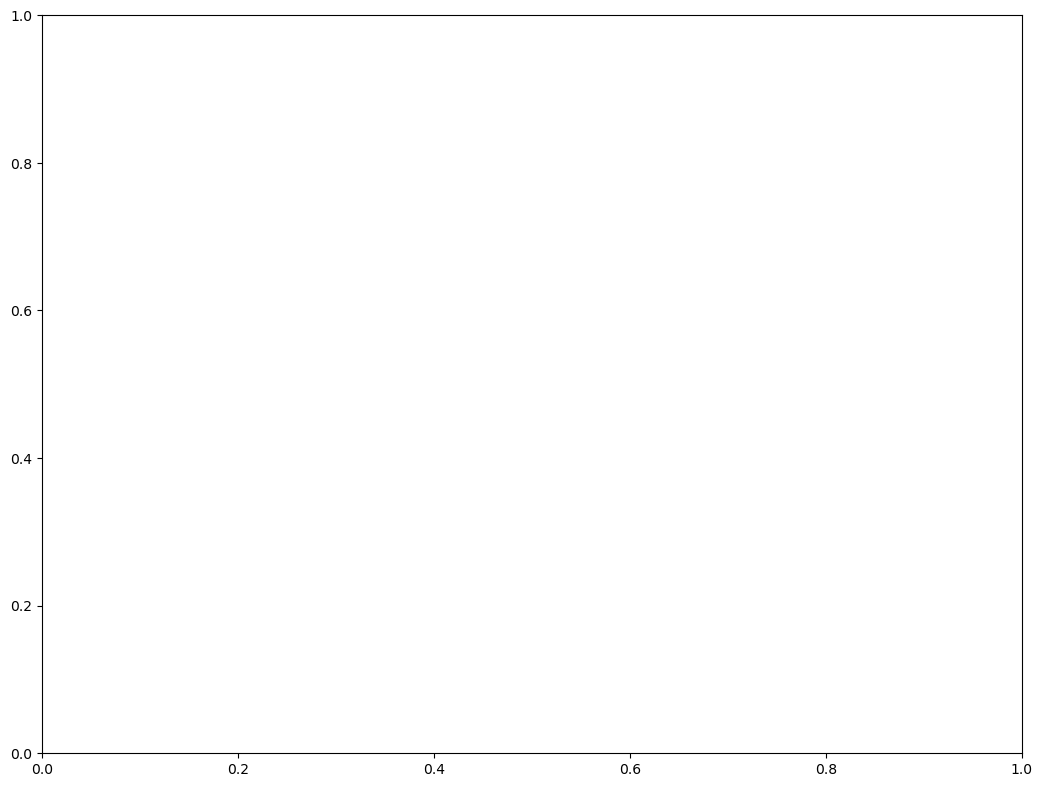

In [8]:
# Generate the dates for our animation frames
start_date = df['timestamp'].min()
end_date = df['timestamp'].max()

# Create dates at yearly end-month points
date_range = pd.date_range(start=start_date, end=end_date, freq='12ME')
if end_date not in date_range:
    date_range = pd.DatetimeIndex(list(date_range) + [end_date])

# Create extended date range with duplicates for pauses
extended_date_range = [date_range[0]] * 1 + list(date_range) + [date_range[-1]] * 3

# Create the figure
fig, ax = plt.subplots(figsize=(14, 9))
plt.subplots_adjust(left=0.25, right=0.95, top=0.92, bottom=0.1)

In [9]:
# Get unique artists
unique_artists = df['artist_name_clean'].unique()

# Define vibrant colors
vibrant_colors = [
    '#e74c3c',  # Red
    '#2ecc71',  # Green
    '#f39c12',  # Orange
    '#9b59b6',  # Purple
    '#1abc9c',  # Teal
    '#34495e',  # Navy blue
    '#f1c40f',  # Yellow
    '#8e44ad',  # Darker purple
    '#16a085',  # Darker teal
    '#2980b9',  # Darker blue
    '#e67e22',  # Lighter orange
    '#27ae60',  # Darker green
    '#5D6D7E',  # Gray-blue
    '#6C3483'   # Dark purple
]

# Assign a vibrant color to each artist
color_map = {}
for i, artist in enumerate(unique_artists):
    color_idx = i % len(vibrant_colors)
    color_map[artist] = vibrant_colors[color_idx]

In [10]:
def animate(i):
    ax.clear()
    
    # Use the extended date range with duplicates
    checkpoint_date = extended_date_range[i]
    subset = df[df['timestamp'] <= checkpoint_date]
    
    # Calculate cumulative play time for each artist
    artist_stats = subset.groupby('artist_name_clean')['ms_played'].sum().reset_index()
    
    # Convert to hours
    artist_stats['hours_played'] = artist_stats['ms_played'] / (1000 * 60 * 60)
    
    # Get top artists
    top_artists = artist_stats.nlargest(5, 'hours_played').sort_values(by='hours_played', ascending=True)
    
    # Use clean names for display to avoid special character issues
    def create_display_label(name):
        original = name_mapping.get(name, name)
        if re.search(r'[^\w\s]', original):
            return name  # Use safe name if contains special chars
        return original
    
    display_names = [create_display_label(name) for name in top_artists['artist_name_clean']]
    
    # Create horizontal bar chart
    colors = [color_map[artist] for artist in top_artists['artist_name_clean']]
    bars = ax.barh(display_names, 
                  top_artists['hours_played'],
                  color=colors)
    
    # Add title with current date
    date_str = checkpoint_date.strftime('%B %Y')
    ax.set_title(f'Most Played Artists (Cumulative) as of {date_str}', fontsize=14)
    
    # Add labels
    ax.set_xlabel('Hours Played', fontsize=12)
    
    # Format hour labels
    def hours_formatter(x, pos):
        return f'{int(x)}h'
    
    ax.xaxis.set_major_formatter(FuncFormatter(hours_formatter))
    
    # Add text labels to the end of bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.0f}h', va='center')
    
    # Determine the x-axis range dynamically with some padding
    max_hours = top_artists['hours_played'].max() * 1.15
    ax.set_xlim(0, max_hours)
    
    # Add vertical gridlines
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Style improvements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Maintain margins throughout animation
    plt.subplots_adjust(left=0.25, right=0.95, top=0.92, bottom=0.1)
    
    return bars

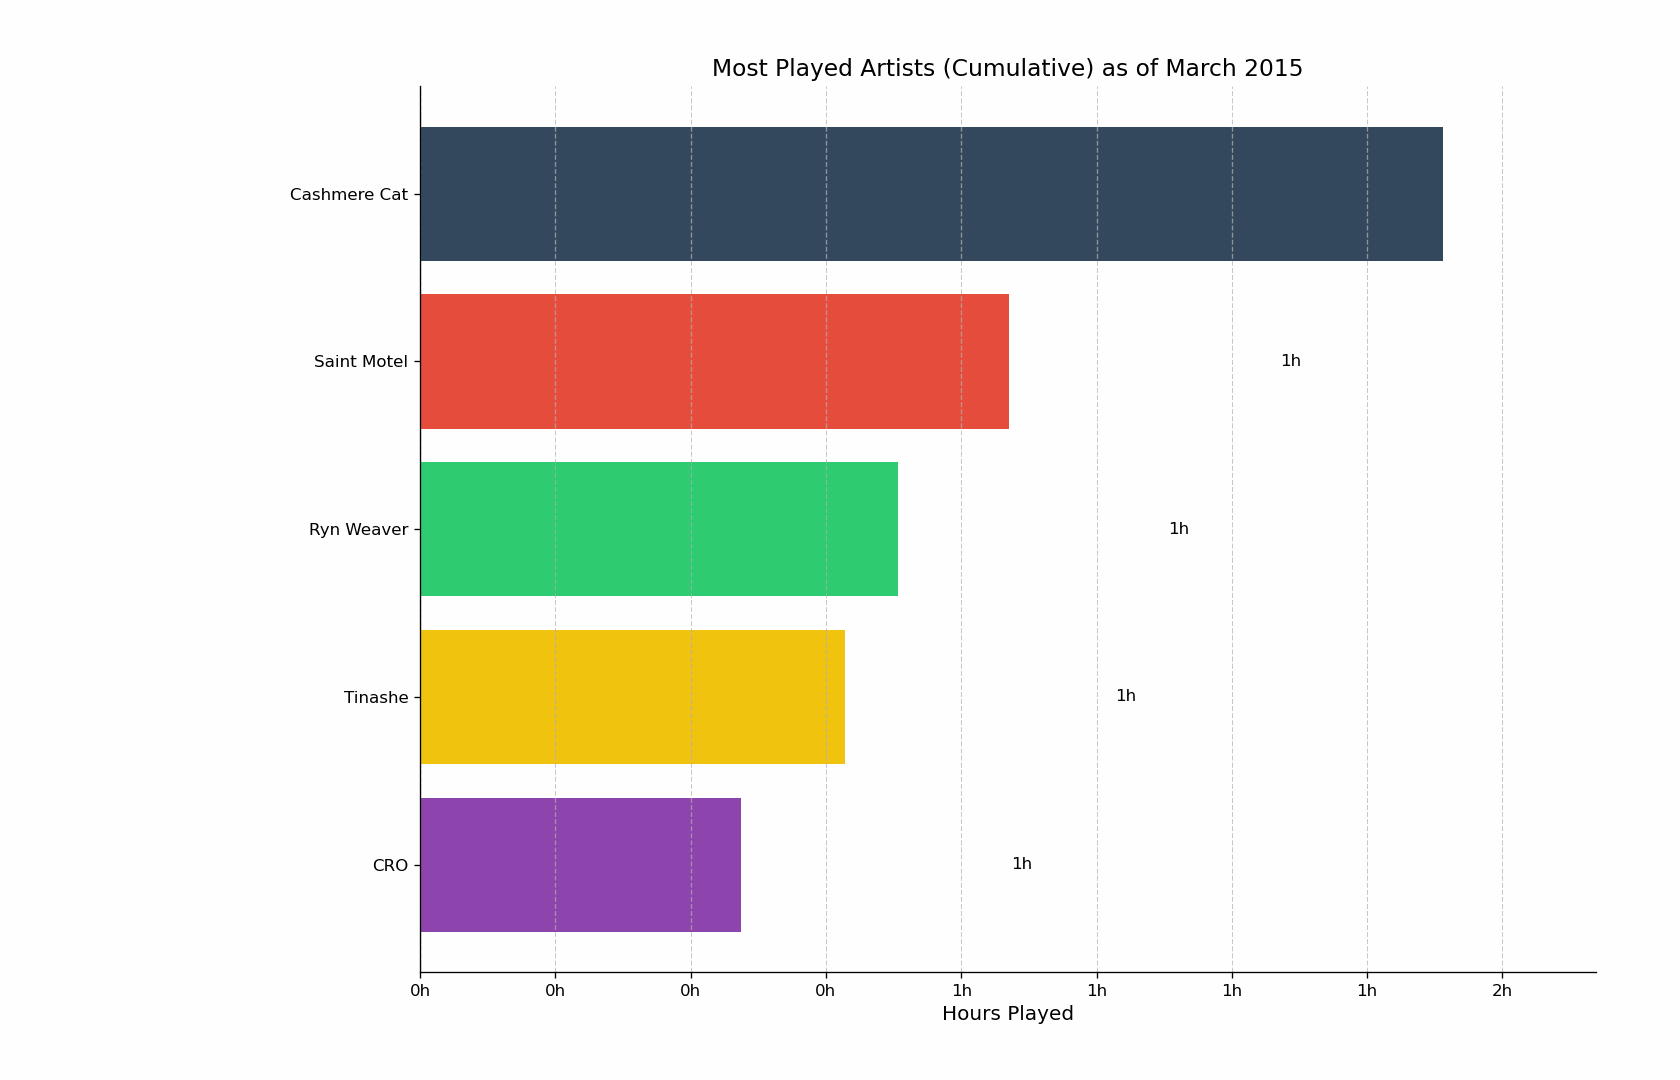

<Figure size 640x480 with 0 Axes>

In [11]:
# Set up the animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(extended_date_range), 
    interval=700, repeat=True
)

# Save the animation
ani.save('graphs/cumulative_artist_progression_v5.gif', 
         writer='pillow', 
         fps=1.5, 
         dpi=120)

# Display the animation in the notebook
from IPython.display import Image
Image(filename='graphs/cumulative_artist_progression_v5.gif')

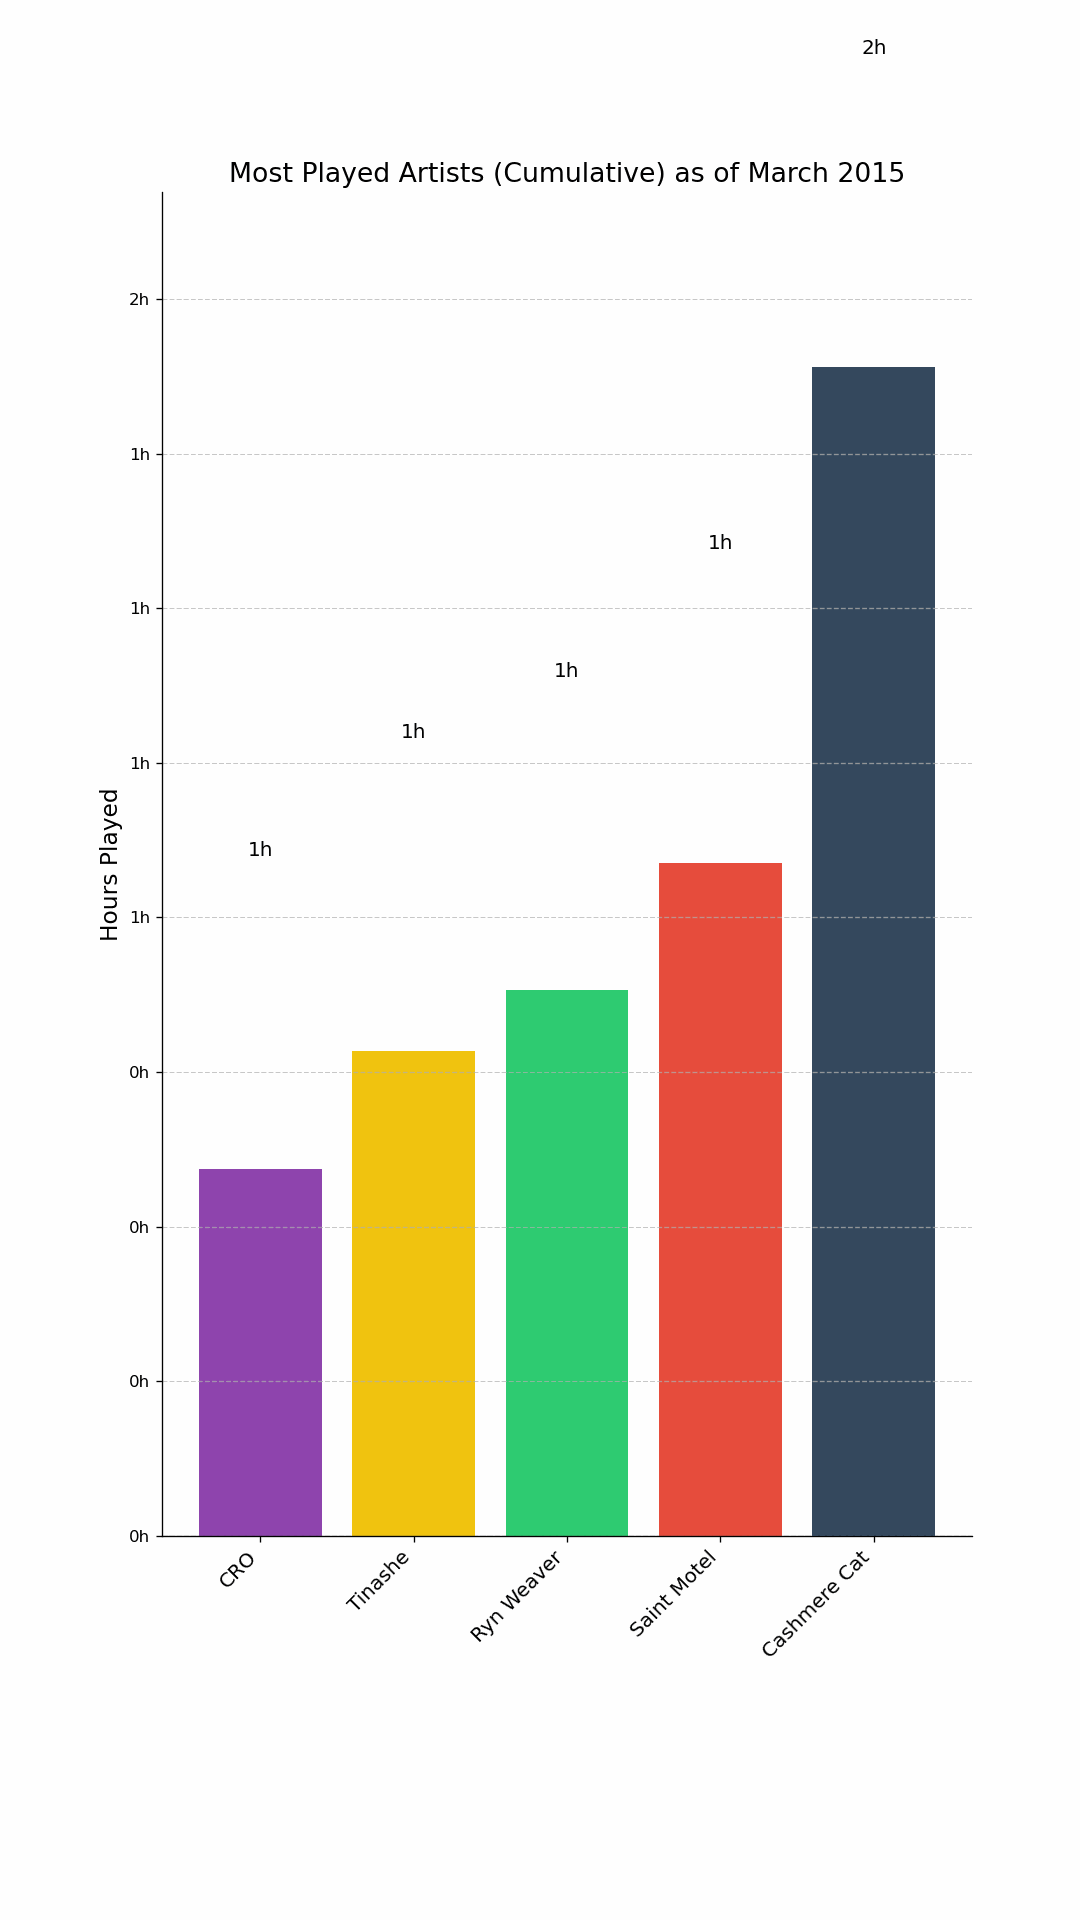

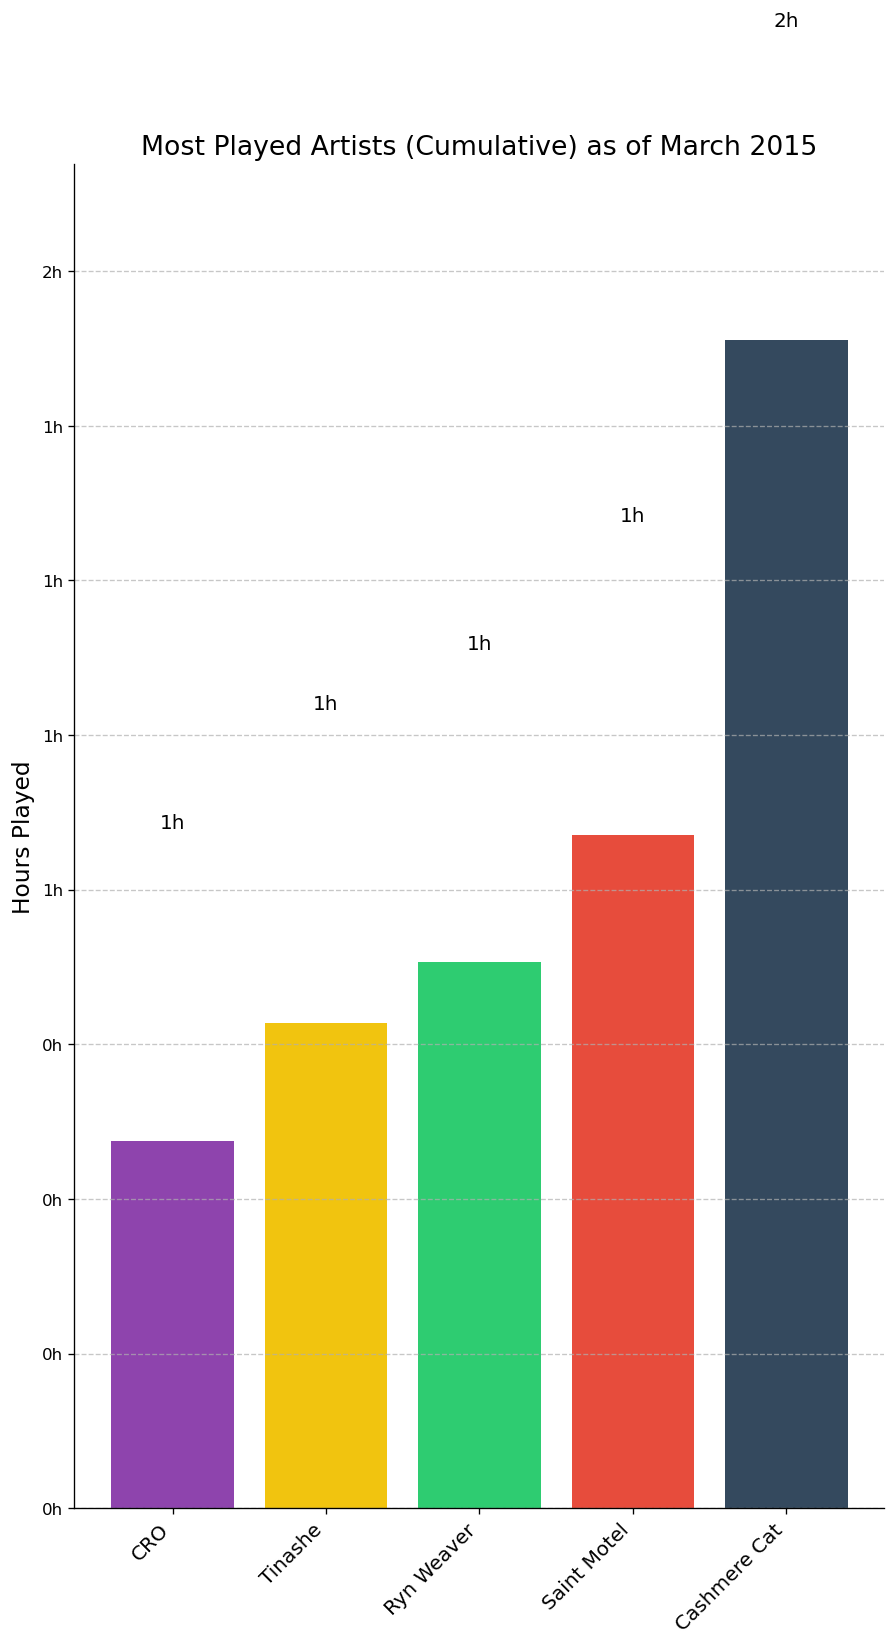

In [12]:
# Minimal changes to convert horizontal to vertical display

# Change the figure size to portrait orientation (9:16 aspect ratio)
fig, ax = plt.subplots(figsize=(9, 16), dpi=120)  

# Your original animate function with minimal changes
def animate(i):
    ax.clear()
    
    # Use the extended date range with duplicates
    checkpoint_date = extended_date_range[i]
    subset = df[df['timestamp'] <= checkpoint_date]
    
    # Calculate cumulative play time for each artist
    artist_stats = subset.groupby('artist_name_clean')['ms_played'].sum().reset_index()
    
    # Convert to hours
    artist_stats['hours_played'] = artist_stats['ms_played'] / (1000 * 60 * 60)
    
    # Get top artists
    top_artists = artist_stats.nlargest(5, 'hours_played').sort_values(by='hours_played')
    
    # Use clean names for display to avoid special character issues
    def create_display_label(name):
        original = name_mapping.get(name, name)
        if re.search(r'[^\w\s]', original):
            return name  # Use safe name if contains special chars
        return original
    
    display_names = [create_display_label(name) for name in top_artists['artist_name_clean']]
    
    # Changed to vertical bars (using bar instead of barh)
    colors = [color_map[artist] for artist in top_artists['artist_name_clean']]
    bars = ax.bar(display_names, 
                 top_artists['hours_played'],
                 color=colors)
    
    # Add title with current date (slightly larger font)
    date_str = checkpoint_date.strftime('%B %Y')
    ax.set_title(f'Most Played Artists (Cumulative) as of {date_str}', fontsize=16)
    
    # Changed from xlabel to ylabel for vertical orientation
    ax.set_ylabel('Hours Played', fontsize=14)
    
    # Format hour labels
    def hours_formatter(y, pos):
        return f'{int(y)}h'
    
    ax.yaxis.set_major_formatter(FuncFormatter(hours_formatter))
    
    # Rotate x labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    # Add text labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
                f'{height:.0f}h', ha='center', va='bottom', fontsize=12)
    
    # Determine the y-axis range dynamically with some padding
    max_hours = top_artists['hours_played'].max() * 1.15
    ax.set_ylim(0, max_hours)
    
    # Add horizontal gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Style improvements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust margins for portrait orientation
    plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.2)
    
    return bars

# Set up the animation - unchanged from your original code
ani = animation.FuncAnimation(
    fig, animate, frames=len(extended_date_range), 
    interval=700, repeat=True
)

# Save as GIF - unchanged from your original code
ani.save('graphs/cumulative_artist_progression_vertical.gif', 
         writer='pillow', 
         fps=1.5, 
         dpi=120)

# Display the animation in the notebook
from IPython.display import Image
Image(filename='graphs/cumulative_artist_progression_vertical.gif')